In [1]:
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive1 = GoogleDrive(gauth)

# Mount drive
drive.mount('/content/gdrive', force_remount=True)
google_folder_id = '1ZbJi6kZ6Xp9Tgh5ctl5TRvkxESVapZNG'

Using TensorFlow backend.


    100% |████████████████████████████████| 993kB 20.4MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# read data
train_x = np.load('/content/gdrive/My Drive/Colab Notebooks/Kaggle/submit/train_x.npy')
train_label = np.load('/content/gdrive/My Drive/Colab Notebooks/Kaggle/submit/train_label.npy')
final_test_x = np.load('/content/gdrive/My Drive/Colab Notebooks/Kaggle/submit/test_x.npy')

# cast as float
train_x = train_x.astype('float32')
final_test_x = final_test_x.astype('float32')

# normalize data
train_x = train_x / 255.
final_test_x = final_test_x / 255.

# convert labels to one hot
train_y = to_categorical(train_label)

In [3]:
# print stats
print("train_x.shape:", train_x.shape)
print("train_label.shape:", train_label.shape)
print("test_x.shape:", final_test_x.shape)

# get number of classes
classes = np.unique(train_label)
class_dict = {cls: i for i, cls in enumerate(classes)}
num_classes = len(classes)
print("Number of classes:", num_classes)

train_x.shape: (760, 168, 308, 3)
train_label.shape: (760,)
test_x.shape: (200, 168, 308, 3)
Number of classes: 20


In [4]:
# split data into training and testing
train_X, test_X, train_Y, test_Y = train_test_split(train_x, train_y, test_size=0.2, random_state=27)

print("Training data:", train_X.shape, ",", train_Y.shape)
print("Testing data:", test_X.shape, ",", test_Y.shape)

Training data: (608, 168, 308, 3) , (608, 20)
Testing data: (152, 168, 308, 3) , (152, 20)


In [0]:
# Data augmentation
train_datagen = ImageDataGenerator(
    data_format='channels_last',
    horizontal_flip = True,
    vertical_flip = True
)
train_datagen.fit(train_X)

In [0]:
# Plot results
def plotResults(train_results):
  accuracy = train_results.history['acc']
  val_accuracy = train_results.history['val_acc']
  loss = train_results.history['loss']
  val_loss = train_results.history['val_loss']
  epochs = range(len(accuracy))
  
  plt.figure()
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [0]:
# set hyperparameters
epochs = 160
steps_per_epoch = 10
validation_steps = 1
batch_size = 100
learning_rate = 0.001
conv_kernel = (4,4)
pool_kernel = (2,2)

CNN 1

In [8]:
# CNN
cnn1 = Sequential()

cnn1.add(Conv2D(32, kernel_size=conv_kernel,activation='linear',activity_regularizer=keras.regularizers.l2(0.02),input_shape=(168, 308, 3),padding='same'))
cnn1.add(LeakyReLU(alpha=0.1))
cnn1.add(MaxPooling2D(pool_kernel,padding='same'))

cnn1.add(Conv2D(64, conv_kernel, activation='linear',padding='same'))
cnn1.add(LeakyReLU(alpha=0.1))
cnn1.add(MaxPooling2D(pool_size=pool_kernel,padding='same'))

cnn1.add(Conv2D(128, conv_kernel, activation='linear',padding='same'))
cnn1.add(LeakyReLU(alpha=0.1))                  
cnn1.add(MaxPooling2D(pool_size=pool_kernel,padding='same'))

cnn1.add(Flatten())

cnn1.add(Dense(64, activation='linear'))
cnn1.add(LeakyReLU(alpha=0.1))
cnn1.add(Dropout(0.4))

cnn1.add(Dense(64, activation='linear'))
cnn1.add(LeakyReLU(alpha=0.1))
cnn1.add(Dropout(0.4))

cnn1.add(Dense(num_classes, activation='softmax'))

cnn1.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    metrics=['accuracy']
)
cnn1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 168, 308, 32)      1568      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 168, 308, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 154, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 84, 154, 64)       32832     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 84, 154, 64)       0         
_________________________________________________________________
max_pooling2d_2 (MaxP

In [0]:
# Callback to save model weights
filepath="/content/gdrive/My Drive/Colab Notebooks/Kaggle/models/model_ite{epoch:03d}-acc{val_acc:.5f}.hdf5"
mcp_save = keras.callbacks.ModelCheckpoint(
    filepath,
    save_best_only=False,
    monitor='val_acc',
    mode='max'
)

In [10]:
# Train model
cnn1_train = cnn1.fit_generator(
    train_datagen.flow(train_X, train_Y, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=(test_X, test_Y),
    callbacks=[mcp_save]
#     callbacks=[]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/160
10/10 [==============================] - 14s 1s/step - loss: 129836.7569 - acc: 0.0841 - val_loss: 37003.7818 - val_acc: 0.0987
Epoch 2/160
10/10 [==============================] - 6s 571ms/step - loss: 24041.1302 - acc: 0.1628 - val_loss: 13105.0122 - val_acc: 0.1184
Epoch 3/160
10/10 [==============================] - 5s 518ms/step - loss: 11873.4636 - acc: 0.1967 - val_loss: 9668.5281 - val_acc: 0.1711
Epoch 4/160
10/10 [==============================] - 6s 568ms/step - loss: 9518.9536 - acc: 0.2548 - val_loss: 7140.9820 - val_acc: 0.2368
Epoch 5/160
10/10 [==============================] - 5s 522ms/step - loss: 6476.7213 - acc: 0.2171 - val_loss: 5337.2636 - val_acc: 0.2237
Epoch 6/160
10/10 [==============================] - 6s 571ms/step - loss: 5602.1249 - acc: 0.2416 - val_loss: 4597.5749 - val_acc: 0.3684
Epoch 7/160
10/10 [==============================] - 5s 534ms/step - loss: 4555.4328 - acc: 0.3293 - val_loss: 393

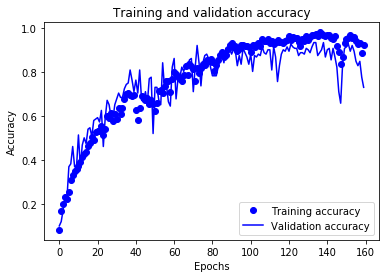

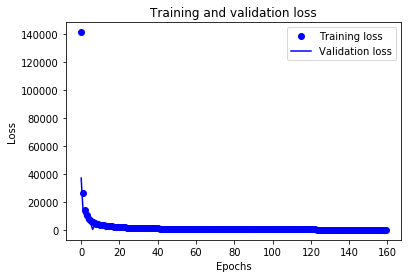

In [11]:
# Plot results
plotResults(cnn1_train)

In [12]:
best_acc = cnn1_train.history['val_acc'][np.argmax(cnn1_train.history['val_acc'])]
best_loss = cnn1_train.history['val_loss'][np.argmax(cnn1_train.history['val_loss'])]

print("Best Loss:", best_loss)
print("Best Accuracy:", best_acc)

Best Loss: 37003.78176398026
Best Accuracy: 0.9342105372955924


In [17]:
# Load in best weights from previous trial
cnn1.load_weights("/content/gdrive/My Drive/Colab Notebooks/Kaggle/submit/model_ite158-acc0.94079.hdf5")
# cnn1.load_weights("/content/gdrive/My Drive/Colab Notebooks/Kaggle/submit/model_ite135-acc0.93421.hdf5")

# Evaluate model on train and test set
train_eval = cnn1.evaluate(train_X, train_Y, verbose=0)
print('Train loss:', train_eval[0])
print('Train accuracy:', train_eval[1])

test_eval = cnn1.evaluate(test_X, test_Y, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Train loss: 86.47247595536082
Train accuracy: 1.0
Test loss: 82.65017900968853
Test accuracy: 0.9407894768212971


In [0]:
# Create submission
submission_name = 'submission_'+str(test_eval[1])+'.csv'

predictions = cnn1.predict(final_test_x)
predictions = np.argmax(predictions, axis=1)

submission_txt = 'Id,Predicted\n'
for i in range(len(predictions)):
  submission_txt += str(i) + "," + str(predictions[i]) + "\n"

submission_file = open(submission_name, "w")
submission_file.write(submission_txt)
submission_file.close()

uploaded = drive1.CreateFile({'title': submission_name, "parents": [{"kind": "drive#fileLink", "id": google_folder_id}]})
uploaded.SetContentFile(submission_name)
uploaded.Upload()